<a href="https://colab.research.google.com/github/Cloblak/aipi540_deeplearning/blob/main/1D_CNN_Attempts/CDT1D_CNN_15FEB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install alpaca_trade_api

     |████████████████████████████████| 45 kB 2.4 MB/s 
     |████████████████████████████████| 636 kB 15.7 MB/s 
     |████████████████████████████████| 53 kB 2.6 MB/s 
     |████████████████████████████████| 103 kB 4.4 MB/s 
     |████████████████████████████████| 1.3 MB 48.1 MB/s 
     |████████████████████████████████| 273 kB 48.2 MB/s 
     |████████████████████████████████| 271 kB 56.9 MB/s 
     |████████████████████████████████| 94 kB 4.3 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: msgpack
    Found existing installation: msgpack 1.0.3
    Uninstalling msgpack-1.0.3:
      Successfully uninstalled msgpack-1.0.3


Features To Consider
 - Targets are only predicting sell within market hours, i.e. at 1530, target is prediciting price for 1100 the next day.  Data from pre and post market is taken into consideration, and a sell or buy will be indicated if the price will flucuate after close.

In [17]:
# Import Dependencies
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
import alpaca_trade_api as tradeapi
from datetime import datetime, timedelta, tzinfo, timezone, time
import os.path
import ast
import threading
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings

In [18]:
random_seed = 182
torch.manual_seed(random_seed)

In [19]:
PAPER_API_KEY = "PKE39LILN9SL1FMJMFV7"
PAPER_SECRET_KEY = "TkU7fXH6WhP15MewgWlSnQG5RUoHGOPQ7yqlD6xq"
PAPER_BASE_URL = 'https://paper-api.alpaca.markets'

In [20]:
api = tradeapi.REST(PAPER_API_KEY, PAPER_SECRET_KEY, PAPER_BASE_URL, api_version='v2')

In [21]:
def prepost_train_test_validate_offset_data(api, ticker, interval, train_days=180, test_days=60, validate_days=30, offset_days = 0):
    ticker_data_dict = None
    ticker_data_dict = {}
    monthly_data_dict = None
    monthly_data_dict = {}
    interval_loop_data = None
    interval_loop_data = pd.DataFrame()
    stock_data = None
    
    days_to_collect = train_days + test_days + validate_days + offset_days

    TZ = 'US/Eastern'

    start = pd.to_datetime((datetime.now() - timedelta(days=days_to_collect)).strftime("%Y-%m-%d %H:%M"), utc=True)
    end = pd.to_datetime(datetime.now().strftime("%Y-%m-%d %H:%M"), utc=True)

    stock_data = api.get_bars(ticker, interval, start = start.isoformat(), end=end.isoformat(), adjustment="raw").df
    
    interval_loop_data = interval_loop_data.append(stock_data)
    df_start_ref = interval_loop_data.index[0]
    start_str_ref = pd.to_datetime(start, utc=True)

    while start_str_ref.value < ( pd.to_datetime(df_start_ref, utc=True) - pd.Timedelta(days=2.5)).value:
        end_new = pd.to_datetime(interval_loop_data.index[0].strftime("%Y-%m-%d %H:%M"), utc=True).isoformat()
        stock_data_new = None
        stock_data_new = api.get_bars(ticker, interval, start=start, end=end_new, adjustment="raw").df
        #stock_data_new = stock_data_new.reset_index()
        interval_loop_data = interval_loop_data.append(stock_data_new).sort_values(by=['index'], ascending=True)
        df_start_ref = interval_loop_data.index[0]
        
    stock_yr_min_df = interval_loop_data.copy()
    stock_yr_min_df["Open"] = stock_yr_min_df['open']
    stock_yr_min_df["High"]= stock_yr_min_df["high"]
    stock_yr_min_df["Low"] = stock_yr_min_df["low"]
    stock_yr_min_df["Close"] = stock_yr_min_df["close"]
    stock_yr_min_df["Volume"] = stock_yr_min_df["volume"]
    stock_yr_min_df["VolumeWeightedAvgPrice"] = stock_yr_min_df["vwap"]
    stock_yr_min_df["Time"] = stock_yr_min_df.index.tz_convert(TZ)
    stock_yr_min_df.index = stock_yr_min_df.index.tz_convert(TZ)
    final_df = stock_yr_min_df.filter(["Time", "Open", "High", "Low", "Close", "Volume", "VolumeWeightedAvgPrice"], axis = 1)
    
    first_day = final_df.index[0]
    traintest_day = final_df.index[-1] - pd.Timedelta(days= test_days+validate_days+offset_days)
    valtest_day = final_df.index[-1] - pd.Timedelta(days= test_days+offset_days)
    last_day = final_df.index[-1] - pd.Timedelta(days= offset_days)
    training_df =  final_df.loc[first_day:traintest_day] #(data_split - pd.Timedelta(days=1))]
    validate_df = final_df.loc[traintest_day:valtest_day]
    testing_df =  final_df.loc[valtest_day:last_day]
    full_train = final_df.loc[first_day:last_day]
    offset_df =  final_df.loc[last_day:]

    return training_df, validate_df, testing_df, full_train, offset_df, final_df, traintest_day, valtest_day

from datetime import date

train_start = date(2017, 1, 1)
train_end = date(2020, 3, 29)
train_delta = train_end - train_start
print(f'Number of days of Training Data {train_delta.days}')

val_day_num = 400
print(f'Number of days of Validation Data {val_day_num}')

test_start = train_end + timedelta(val_day_num)
test_end = date.today()
test_delta = (test_end - test_start)
print(f'Number of days of Holdout Test Data {test_delta.days}')

ticker = "CORN" # Ticker Symbol to Test
interval = "5Min" # Interval of bars
train_day_int = train_delta.days # Size of training set (Jan 2010 - Oct 2017)
val_day_int = val_day_num # Size of validation set
test_day_int = test_delta.days # Size of test set
offset_day_int = 0 # Number of days to off set the training data
train_raw, val_raw, test_raw, full_raw, offset_raw, complete_raw, traintest_day, testval_day = prepost_train_test_validate_offset_data(api, ticker, 
                                                                                     interval, 
                                                                                     train_days=train_day_int, 
                                                                                     test_days=test_day_int, 
                                                                                     validate_days=val_day_int,
                                                                                     offset_days = offset_day_int)

def timeFilterAndBackfill(df):
  """ 
  Prep df to be filled out for each trading day:
    Time Frame: 0930-1930
    Backfilling NaNs
    Adjusting Volume to Zero if no Trading data is present
      - Assumption is that there were no trades duing that time 

  We will build over lapping arrays by 30 min to give ourselfs more
  oppurtunities to predict during a given trading day 
  """
  
  df = df.between_time('07:29','17:29') # intial sorting of data

  TZ = 'US/Eastern' # define the correct timezone

  start_dateTime = pd.Timestamp(year = df.index[0].year, 
                                month = df.index[0].month, 
                                day = df.index[0].day, 
                                hour = 7, minute = 25, tz = TZ)

  end_dateTime = pd.Timestamp(year = df.index[-1].year, 
                              month = df.index[-1].month, 
                              day = df.index[-1].day, 
                              hour = 17, minute = 35, tz = TZ)

  # build blank index that has ever 5 min interval represented
  dateTime_index = pd.date_range(start_dateTime,
                                end_dateTime, 
                                freq='5min').tolist()

  dateTime_index_df = pd.DataFrame()
  dateTime_index_df["Time"] = dateTime_index 
  filtered_df = pd.merge_asof(dateTime_index_df, df,  
                              on='Time').set_index("Time").between_time('09:29','17:29')

  # create the close array by back filling NA, to represent no change in close
  closeset_list = []
  prev_c = None

  for c in filtered_df["Close"]:

    if prev_c == None:
      if math.isnan(c):
        prev_c = 0
        closeset_list.append(0)
      else:
        prev_c = c
        closeset_list.append(c)
    
    elif prev_c != None:
      if c == prev_c:
        closeset_list.append(c)
      elif math.isnan(c):
        closeset_list.append(prev_c)
      else:
        closeset_list.append(c)
        prev_c = c
    
  filtered_df["Close"] = closeset_list

  # create the volume
  volumeset_list = []
  prev_v = None

  for v in filtered_df["Volume"]:
    
    if prev_v == None:
      if math.isnan(v):
        prev_v = 0
        volumeset_list.append(0)
      else:
        prev_v = v
        volumeset_list.append(v)

    elif prev_v != None:
      if v == prev_v:
        volumeset_list.append(0)
        prev_v = v
      elif math.isnan(v):
        volumeset_list.append(0)
        prev_v = 0
      else:
        volumeset_list.append(v)
        prev_v = v

  filtered_df["Volume"] = volumeset_list
  
  adjvolumeset_list = []
  prev_v = None

  for v in filtered_df["VolumeWeightedAvgPrice"]:
    if prev_v == None:
      if math.isnan(v):
        prev_v = 0
        adjvolumeset_list.append(0)
      else:
        prev_v = v
        adjvolumeset_list.append(v)
    elif prev_v != None:
      if v == prev_v:
        adjvolumeset_list.append(0)
        prev_v = v
      elif math.isnan(v):
        adjvolumeset_list.append(0)
        prev_v = 0
      else:
        adjvolumeset_list.append(v)
        prev_v = v

  filtered_df["VolumeWeightedAvgPrice"] = adjvolumeset_list

  preped_df = filtered_df.backfill()

  return preped_df  

Number of days of Training Data 1183
Number of days of Validation Data 400
Number of days of Holdout Test Data 288


In [22]:
train_raw[275:300]

,Time,Open,High,Low,Close,Volume,VolumeWeightedAvgPrice
timestamp,,,,,,,
2017-01-11 13:35:00-05:00,2017-01-11 13:35:00-05:00,18.9885,18.9885,18.9885,18.9885,1003,18.988500
2017-01-11 13:40:00-05:00,2017-01-11 13:40:00-05:00,18.9600,18.9600,18.9600,18.9600,100,18.960000
2017-01-11 13:50:00-05:00,2017-01-11 13:50:00-05:00,19.0000,19.0000,19.0000,19.0000,2300,19.000000
2017-01-11 14:05:00-05:00,2017-01-11 14:05:00-05:00,19.0800,19.0800,19.0800,19.0800,300,19.080000
2017-01-11 14:10:00-05:00,2017-01-11 14:10:00-05:00,19.0835,19.0835,19.0835,19.0835,500,19.083500
2017-01-11 14:15:00-05:00,2017-01-11 14:15:00-05:00,19.0652,19.0652,19.0652,19.0652,1414,19.065200
2017-01-11 14:20:00-05:00,2017-01-11 14:20:00-05:00,19.0757,19.0860,19.0757,19.0860,1064,19.078256
2017-01-11 15:00:00-05:00,2017-01-11 15:00:00-05:00,19.0640,19.0640,19.0640,19.0640,500,19.064000
2017-01-11 15:05:00-05:00,2017-01-11 15:05:00-05:00,19.0800,19.0800,19.0600,19.0600,1621,19.061912


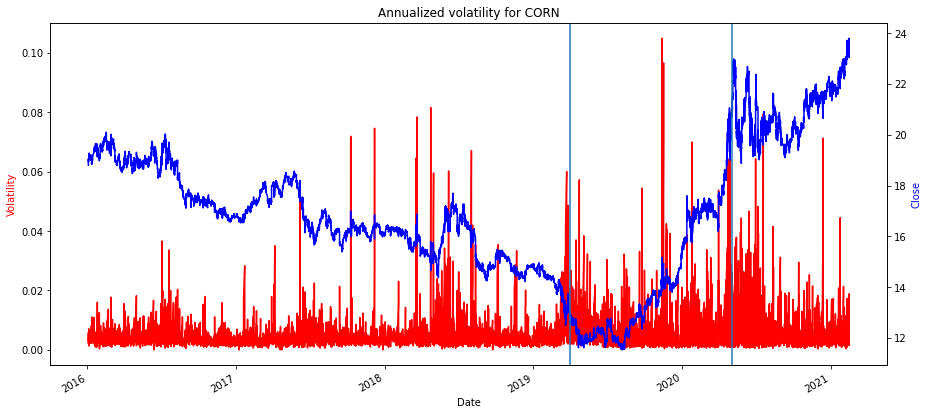

In [23]:
def buildTargets_VolOnly(full_df = full_raw, train_observations = train_raw.shape[0], 
                         val_observations = val_raw.shape[0], 
                         test_observations = test_raw.shape[0], 
                         alph = .55, volity_int = 10):

  """ 
  This function will take a complete set of train, val, and test data and return the targets.
  Volitility will be calculated over the 252 5min incriments 
  The Target shift is looking at 2 hours shift from current time
  """

  returns = np.log(full_df['Close']/(full_df['Close'].shift()))
  returns.fillna(0, inplace=True)
  volatility = returns.rolling(window=(volity_int)).std()*np.sqrt(volity_int)



  return volatility
  #return train_targets, val_targets, test_targets, full_targets

volatility = buildTargets_VolOnly()

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(1, 1, 1)
volatility.plot(ax=ax1, color = "red")
ax1.set_xlabel('Date')
ax1.set_ylabel('Volatility', color = "red")
ax1.set_title(f'Annualized volatility for {ticker}')
ax2 = ax1.twinx()
full_raw.Close.plot(ax=ax2, color = "blue")
ax2.set_ylabel('Close', color = "blue")
ax2.axvline(x=full_raw.index[train_raw.shape[0]])
ax2.axvline(x=full_raw.index[val_raw.shape[0]+train_raw.shape[0]])
plt.show()

In [24]:
train = timeFilterAndBackfill(train_raw)
val = timeFilterAndBackfill(val_raw)
test = timeFilterAndBackfill(test_raw)

train = train[train.index.dayofweek <= 4].copy()
val = val[val.index.dayofweek <= 4].copy()
test = test[test.index.dayofweek <= 4].copy()

train["Open"] = np.where((train["Volume"] == 0), train["Close"], train["Open"])
train["High"] = np.where((train["Volume"] == 0), train["Close"], train["High"])
train["Low"] = np.where((train["Volume"] == 0), train["Close"], train["Low"])

val["Open"] = np.where((val["Volume"] == 0), val["Close"], val["Open"])
val["High"] = np.where((val["Volume"] == 0), val["Close"], val["High"])
val["Low"] = np.where((val["Volume"] == 0), val["Close"], val["Low"])

test["Open"] = np.where((test["Volume"] == 0), test["Close"], test["Open"])
test["High"] = np.where((test["Volume"] == 0), test["Close"], test["High"])
test["Low"] = np.where((test["Volume"] == 0), test["Close"], test["Low"])

def strided_axis0(a, L, overlap=1):
    if L==overlap:
        raise Exception("Overlap arg must be smaller than length of windows")
    S = L - overlap
    nd0 = ((len(a)-L)//S)+1
    if nd0*S-S!=len(a)-L:
        warnings.warn("Not all elements were covered")
    m,n = a.shape
    s0,s1 = a.strides
    return np.lib.stride_tricks.as_strided(a, shape=(nd0,L,n), strides=(S*s0,s0,s1))

# OLDER CODE WITHOUT OVERLAP OF LABELING
# def blockshaped(arr, nrows, ncols):
#     """
#     Return an array of shape (n, nrows, ncols) where
#     n * nrows * ncols = arr.size

#     If arr is a 2D array, the returned array should look like n subblocks with
#     each subblock preserving the "physical" layout of arr.
#     """
#     h, w = arr.shape
#     assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
#     assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"
#     return np.flip(np.rot90((arr.reshape(h//nrows, nrows, -1, ncols)
#                .swapaxes(1,2)
#                .reshape(-1, nrows, ncols)), axes = (1, 2)), axis = 1)


def blockshaped(arr, nrows, ncols, overlapping_5min_intervals = 12):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """

    h, w = arr.shape
    assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
    assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"

    return np.flip(np.rot90((strided_axis0(arr, 24, overlap=overlapping_5min_intervals).reshape(-1, nrows, ncols)), axes = (1, 2)), axis = 1)

train_tonp = train[["Open", "High", "Low", "Close", "Volume"]]
val_tonp = val[["Open", "High", "Low", "Close", "Volume"]]
test_tonp = test[["Open", "High", "Low", "Close", "Volume"]]
train_array = train_tonp.to_numpy()
val_array = val_tonp.to_numpy()
test_array = test_tonp.to_numpy()

X_train_pre_final = blockshaped(train_array, 24, 5, overlapping_5min_intervals = 12)
X_val_pre_final = blockshaped(val_array, 24, 5, overlapping_5min_intervals = 12)
X_test_pre_final = blockshaped(test_array, 24, 5, overlapping_5min_intervals = 12)

# X_train_pre_final = blockshaped(train_array, 24, 5)
# X_val_pre_final = blockshaped(val_array, 24, 5)
# X_test_pre_final = blockshaped(test_array, 24, 5)

In [25]:
X_train_pre_final[0]

array([[1.88000e+01, 1.88101e+01, 1.88100e+01, 1.88270e+01, 1.88856e+01,
        1.88544e+01, 1.88700e+01, 1.88599e+01, 1.88643e+01, 1.88500e+01,
        1.88500e+01, 1.88528e+01, 1.88300e+01, 1.88800e+01, 1.88761e+01,
        1.88900e+01, 1.89172e+01, 1.89100e+01, 1.89100e+01, 1.89300e+01,
        1.89500e+01, 1.90000e+01, 1.90200e+01, 1.89945e+01],
       [1.88000e+01, 1.88400e+01, 1.88100e+01, 1.88708e+01, 1.88856e+01,
        1.88544e+01, 1.88700e+01, 1.88599e+01, 1.88643e+01, 1.88500e+01,
        1.88500e+01, 1.88528e+01, 1.88600e+01, 1.88800e+01, 1.88761e+01,
        1.89100e+01, 1.89172e+01, 1.89100e+01, 1.89100e+01, 1.89300e+01,
        1.89500e+01, 1.90300e+01, 1.90200e+01, 1.89945e+01],
       [1.88000e+01, 1.88100e+01, 1.88100e+01, 1.88270e+01, 1.88544e+01,
        1.88544e+01, 1.88400e+01, 1.88599e+01, 1.88510e+01, 1.88500e+01,
        1.88500e+01, 1.88300e+01, 1.88300e+01, 1.88800e+01, 1.88761e+01,
        1.88900e+01, 1.89172e+01, 1.89000e+01, 1.89100e+01, 1.89300e+01,
  

In [26]:
# create target from OHLC and Volume Data
def buildTargets(obs_array,  
                 alph = .55, 
                 volity_int = 10):

  """ 
  This function will take a complete set of train, val, and test 
  data and return the targets. Volitility will be calculated over 
  the 24 5min incriments. The Target shift is looking at 2 hours 
  shift from current time

  shift_2hour = The amount of time the data interval take to equal 2 hours 
                (i.e. 5 min data interval is equal to 24)
  alph = The alpha value for calculating the shift in price
  volity_int = the number of incriments used to calculate volitility 
  """

  target_close_list =[]

  for arr in obs_array:
    target_close_list.append(arr[3][-1])
  
  target_close_df = pd.DataFrame()
  target_close_df["Close"] = target_close_list

  target_close_df["Volitility"] = target_close_df["Close"].rolling(volity_int).std()

  # print(len(volatility), len(target_close_df["Close"]))

  
  targets = [2] * len(target_close_df.Close)

  targets = np.where(target_close_df.Close.shift() >= (target_close_df.Close * (1 + alph * target_close_df["Volitility"])), 
           1, targets)
  
  targets = np.where(target_close_df.Close.shift() <= (target_close_df.Close * (1 - alph * target_close_df["Volitility"])), 
           0, targets)

  return targets

In [27]:
volity_val = 10
alph = .015
y_train_pre_final = buildTargets(X_train_pre_final, alph=alph,  volity_int = volity_val)
y_val_pre_final = buildTargets(X_val_pre_final, alph=alph, volity_int = volity_val)
y_test_pre_final = buildTargets(X_test_pre_final, alph=alph, volity_int = volity_val)

In [28]:
def get_class_distribution(obj):
    count_dict = {
        "up": 0,
        "flat": 0,
        "down": 0,
    }
    
    for i in obj:
        if i == 1: 
            count_dict['up'] += 1
        elif i == 0: 
            count_dict['down'] += 1
        elif i == 2: 
            count_dict['flat'] += 1             
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

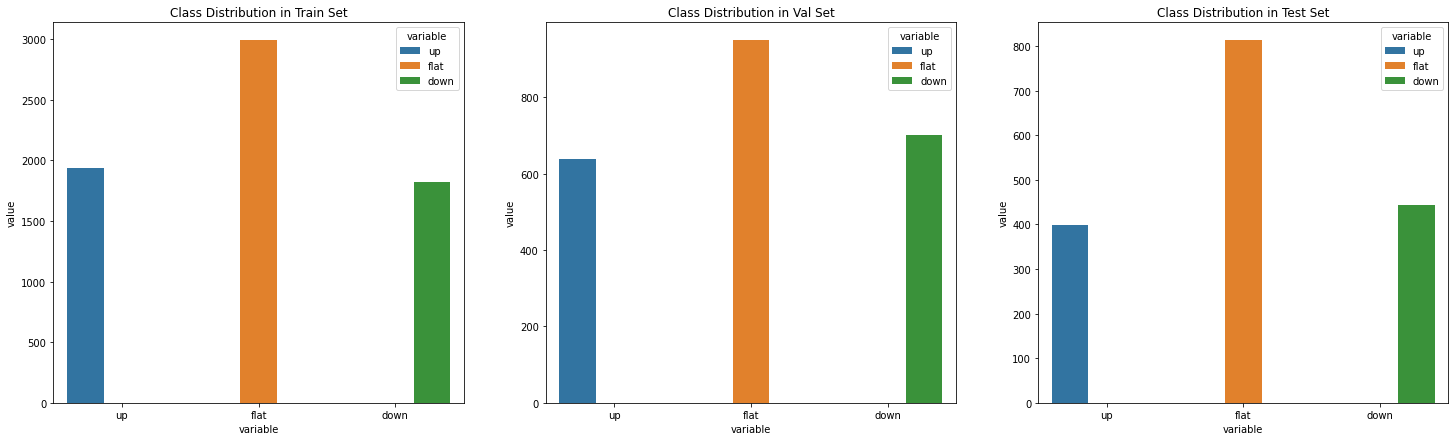

In [29]:
bfig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train_pre_final)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val_pre_final)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test_pre_final)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [44]:
def createFinalData_RemoveLateAfternoonData(arr, labels):

  assert arr.shape[0] == len(labels), "X data do not match length of y labels"

  step_count = 0
  filtered_y_labels = []

  for i in range(arr.shape[0]):

    if i == 0:
      final_arr = arr[i]
      filtered_y_labels.append(labels[i])
      #print(f'Appending index {i}, step_count: {step_count}')
      step_count += 1

    elif i == 1:

      final_arr = np.stack((final_arr, arr[i]))
      filtered_y_labels.append(labels[i])
      step_count += 1

    elif step_count == 0: 
      final_arr = np.vstack((final_arr, arr[i][None]))
      filtered_y_labels.append(labels[i])
      #print(f'Appending index {i}, step_count: {step_count}')
      step_count += 1
    
    elif (step_count) % 5 == 0:
      #print(f'skipping {i} array, step_count: {step_count}')
      step_count += 1

    elif (step_count) % 6 == 0:
      #print(f'skipping {i} array, step_count: {step_count}')
      step_count += 1

    elif (step_count) % 7 == 0:
      #print(f'skipping {i} array, step_count: {step_count}')
      step_count = 0
    
    else:
      final_arr = np.vstack((final_arr, arr[i][None]))
      filtered_y_labels.append(labels[i])
      #print(f'Appending index {i}, step_count: {step_count}')
      step_count += 1
  
  return final_arr, filtered_y_labels

X_train, y_train = createFinalData_RemoveLateAfternoonData(X_train_pre_final, y_train_pre_final)
X_val, y_val = createFinalData_RemoveLateAfternoonData(X_val_pre_final, y_val_pre_final)
X_test, y_test = createFinalData_RemoveLateAfternoonData(X_test_pre_final, y_test_pre_final)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [31]:
# Check it arrays are made correctly
train[12:48]

,Open,High,Low,Close,Volume,VolumeWeightedAvgPrice
Time,,,,,,
2017-01-03 10:30:00-05:00,18.8300,18.8600,18.8300,18.8600,375.0,18.850000
2017-01-03 10:35:00-05:00,18.8800,18.8800,18.8800,18.8800,325.0,18.880000
2017-01-03 10:40:00-05:00,18.8761,18.8761,18.8761,18.8761,200.0,18.876100
2017-01-03 10:45:00-05:00,18.8900,18.9100,18.8900,18.9100,576.0,18.893472
2017-01-03 10:50:00-05:00,18.9172,18.9172,18.9172,18.9172,1000.0,18.917200
2017-01-03 10:55:00-05:00,18.9100,18.9100,18.9000,18.9100,39966.0,18.909408
2017-01-03 11:00:00-05:00,18.9100,18.9100,18.9100,18.9100,0.0,0.000000
2017-01-03 11:05:00-05:00,18.9300,18.9300,18.9300,18.9300,2040.0,18.930000
2017-01-03 11:10:00-05:00,18.9500,18.9500,18.9500,18.9500,1000.0,18.950000


In [32]:
np.set_printoptions(threshold=200)
y_train_pre_final[0:24]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 0, 0, 0, 2, 1, 1, 2,
       2, 1])

In [33]:
######
# Code fro scaling at a later date
######

# from sklearn.preprocessing import MinMaxScaler

scalers = {}
for i in range(X_train.shape[1]):
    scalers[i] = MinMaxScaler()
    X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 

for i in range(X_val.shape[1]):
    scalers[i] = MinMaxScaler()
    X_val[:, i, :] = scalers[i].fit_transform(X_val[:, i, :]) 

for i in range(X_test.shape[1]):
    scalers[i] = MinMaxScaler()
    X_test[:, i, :] = scalers[i].fit_transform(X_test[:, i, :]) 
    

In [34]:
def get_class_distribution(obj):
    count_dict = {
        "up": 0,
        "flat": 0,
        "down": 0,
    }
    
    for i in obj:
        if i == 1: 
            count_dict['up'] += 1
        elif i == 0: 
            count_dict['down'] += 1
        elif i == 2: 
            count_dict['flat'] += 1             
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

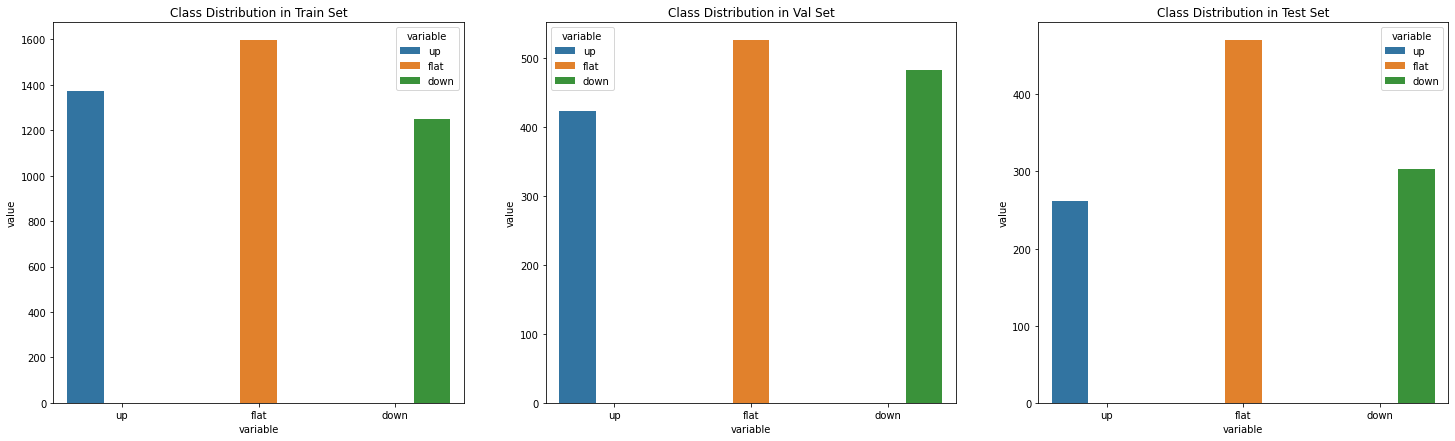

In [35]:
bfig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [ ]:
###### ONLY EXECUTE FOR 2D CNN #####

# X_train = X_train.reshape(X_train.shape[0], 
#                           X_train.shape[1], 
#                           X_train.shape[2],
#                           1)
# X_val = X_val.reshape(X_val.shape[0],
#                           X_val.shape[1], 
#                           X_val.shape[2],
#                           1)
# X_test = X_test.reshape(X_test.shape[0],
#                           X_test.shape[1], 
#                           X_test.shape[2],
#                           1)

In [46]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 3)
y_val = to_categorical(y_val, 3)
y_test = to_categorical(y_test, 3)


In [47]:
print(f'X Train Length {X_train.shape}, y Train Label Length {y_train.shape}')
print(f'X Val Length {X_val.shape}, y Val Label Length {y_val.shape}')
print(f'X Test Length {X_test.shape}, y Test Label Length {y_test.shape}')

X Train Length (4220, 5, 24), y Train Label Length (4220, 3)
X Val Length (1430, 5, 24), y Val Label Length (1430, 3)
X Test Length (1035, 5, 24), y Test Label Length (1035, 3)


# KERAS 1D Model

In [69]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.optimizers import Adam, Nadam

In [37]:
def calculate_weighted_f_score(y_true, y_pred):
  test_preds = np.argmax(y_pred, axis=1)
  Ntu = sum((test_preds == 1) & (y_true == 1))
  Ntd = sum((test_preds == 0) & (y_true == 0))
  Ntf = sum((test_preds == 2) & (y_true == 2))
  Ewutd = sum((test_preds == 1) & (y_true == 0))
  Ewdtu = sum((test_preds == 0) & (y_true == 1))
  Ewutf = sum((test_preds == 1) & (y_true == 2))
  Ewdtf = sum((test_preds == 0) & (y_true == 2))
  Ewftu = sum((test_preds == 2) & (y_true == 1))
  Ewftd = sum((test_preds == 2) & (y_true == 0))

  beta_1 = 0.5
  beta_2 = 0.125
  beta_3 = 0.125

  Ntp = Ntu + Ntd + beta_3**2 * Ntf
  E1 = Ewutd + Ewdtu
  E2 = Ewutf + Ewdtf
  E3 = Ewftu + Ewftd

  F = (1 + beta_1**2 + beta_2**2) * Ntp / ((1+beta_1**2+beta_2**2) * Ntp + E1 + beta_1**2 * E2 + beta_2**2 * E3)
  return F

In [50]:
print(X_train.shape[1],X_train.shape[2])

5 24


In [65]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(MaxPooling1D(pool_size=3, strides=4, padding='same'))
model.add(Dropout(0.7))
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
model.add(Dropout(0.7))
model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))
model.add(Dropout(0.7))
model.add(Flatten())
model.add(Dense(1000,activation="relu"))
model.add(Dense(500,activation="relu"))
model.add(Dense(3,activation="softmax"))
# model.add(Dense(3,activation="softmax"))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_14 (Conv1D)          (None, 5, 32)             2336      
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 2, 32)            0         
 g1D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 2, 32)             0         
                                                                 
 conv1d_15 (Conv1D)          (None, 2, 64)             6208      
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 1, 64)            0         
 g1D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 1, 64)            

In [70]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0001)
nadam = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy']) 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


In [71]:
batch_size = 12
hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=50, validation_data=(X_val, y_val)) #, class_weight={0:2, 1:3, 2:1})

Epoch 1/50
352/352 [==============================] - 3s 7ms/step - loss: 84.5332 - accuracy: 0.3448 - val_loss: 1.6806 - val_accuracy: 0.3622
Epoch 2/50
352/352 [==============================] - 2s 6ms/step - loss: 2.5392 - accuracy: 0.3626 - val_loss: 1.1435 - val_accuracy: 0.3650
Epoch 3/50
352/352 [==============================] - 2s 5ms/step - loss: 1.3078 - accuracy: 0.3818 - val_loss: 1.1078 - val_accuracy: 0.3636
Epoch 4/50
352/352 [==============================] - 2s 5ms/step - loss: 1.1795 - accuracy: 0.3727 - val_loss: 1.1032 - val_accuracy: 0.3664
Epoch 5/50
352/352 [==============================] - 2s 5ms/step - loss: 1.1452 - accuracy: 0.3770 - val_loss: 1.1045 - val_accuracy: 0.3671
Epoch 6/50
352/352 [==============================] - 2s 5ms/step - loss: 1.1271 - accuracy: 0.3770 - val_loss: 1.1025 - val_accuracy: 0.3685
Epoch 7/50
352/352 [==============================] - 2s 5ms/step - loss: 1.1094 - accuracy: 0.3780 - val_loss: 1.0995 - val_accuracy: 0.3671
Epoch

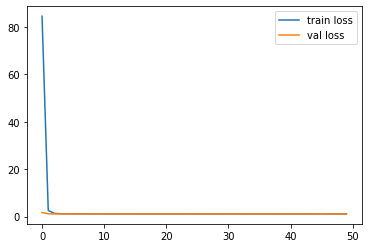

<Figure size 432x288 with 0 Axes>

In [72]:
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

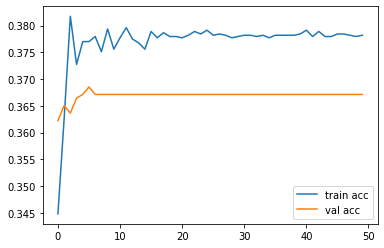

<Figure size 432x288 with 0 Axes>

In [73]:
plt.plot(hist.history['accuracy'], label='train acc')
plt.plot(hist.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [74]:
y_pred = model.predict(X_test)

In [75]:
# Calculate the accuracy
test_preds = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
test_acc = np.sum(test_preds == y_true)/y_true.shape[0]

# Recall for each class
recall_vals = []
for i in range(3):
    class_idx = np.argwhere(y_true==i)
    total = len(class_idx)
    correct = np.sum(test_preds[class_idx]==i)
    recall = correct / total
    recall_vals.append(recall)

classes = [0,1,2]
# Calculate the test set accuracy and recall for each class
print('Test set accuracy is {:.3f}'.format(test_acc))
for i in range(3):
    print('For class {}, recall is {:.3f}'.format(classes[i],recall_vals[i]))

print("Weighted F score is {:.3f}".format(calculate_weighted_f_score(y_true, y_pred)))

Test set accuracy is 0.454
For class 0, recall is 0.000
For class 1, recall is 0.000
For class 2, recall is 1.000
Weighted F score is 0.513


# Completely New Model Build

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D

In [ ]:
model = Sequential()
model.add(Conv2D(32, (1, 3), activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])))
model.add(MaxPooling2D((1, 4), strides=4))
model.add(Dropout(0.7))
model.add(Conv2D(64, (1, 3), activation='relu', padding='same',))
model.add(MaxPooling2D((1, 3), strides=3))
model.add(Dropout(0.7))
model.add(Conv2D(128, (1, 3), activation='relu', padding='same',))
model.add(MaxPooling2D((1, 2), strides=2))
model.add(Dropout(0.7))

model.add(Flatten())
model.add(Dense(1000,activation="relu"))
model.add(Dense(500,activation="relu"))
model.add(Dense(3,activation="softmax"))

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 5, 24, 32)         128       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 2, 6, 32)         0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 2, 6, 32)          0         
                                                                 
 conv2d_23 (Conv2D)          (None, 2, 6, 64)          6208      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 1, 2, 64)         0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 1, 2, 64)         

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy']) 

In [ ]:
batch_size = 12
hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=50, validation_data=(X_val, y_val))

##### LABLES NEED TO BY 1x3 ARRAY

Epoch 1/50
352/352 [==============================] - 10s 5ms/step - loss: 1.1026 - accuracy: 0.3635 - val_loss: 1.0981 - val_accuracy: 0.3671
Epoch 2/50
352/352 [==============================] - 2s 5ms/step - loss: 1.0940 - accuracy: 0.3780 - val_loss: 1.0986 - val_accuracy: 0.3671
Epoch 3/50
352/352 [==============================] - 2s 5ms/step - loss: 1.0958 - accuracy: 0.3765 - val_loss: 1.0988 - val_accuracy: 0.3671
Epoch 4/50
352/352 [==============================] - 2s 5ms/step - loss: 1.0938 - accuracy: 0.3770 - val_loss: 1.0990 - val_accuracy: 0.3671
